In [2]:
import torch
from torchvision import models
from torch.autograd import Function
import matplotlib.pyplot as plt 
from medcam import medcam
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from matplotlib.colors import LinearSegmentedColormap
torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = torch.device("cuda")
import pandas as pd 

In [3]:
# Load model
import monai
resnet_model=monai.networks.nets.resnet50(
    pretrained=False,
    spatial_dims=3,
    n_input_channels=1, 
    num_classes=1)
checkpoint = torch.load("Collection/version_3033490/c-epoch=167-val_loss_epoch=tensor(0.5776, device='cuda_0').ckpt")
weights_dict = {k.replace('_model.', ''): v for k, v in checkpoint['state_dict'].items()}
model_dict = resnet_model.state_dict()
model_dict.update(weights_dict)
resnet_model.load_state_dict(model_dict)
resnet_model = resnet_model.to(device) 

patientlist = pd.read_csv('img-preds.csv')
patientlist = list(patientlist.MRN)

In [13]:
# plotting function
def plot_slices(original, attention, slice, threshold, patient):
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 1, figsize=(5*1, 5))
    
    # Rotate the original and attention maps by 90 degrees
    original = np.rot90(original, k=-1)
    attention = np.rot90(attention, k=-1)
    
    image_stack = original[:, :, slice:(slice+10)]
    axes.imshow(original[:, :, slice], cmap='gray')
    #axes.set_facecolor('black')  
    #fig.patch.set_facecolor('black') 
    attention_stack = attention[:, :, slice:(slice+10)]
    attention_mip = np.max(attention_stack, axis=2)
    
    min_value = np.min(attention_mip)
    max_value = np.max(attention_mip)
    threshold = ((max_value - min_value) * 5/10) + min_value 
    print(f"Min: {min_value}, Max: {max_value}, Calculated Threshold: {threshold}")
    masked_attention = np.ma.masked_less(attention_mip, threshold)
    
    cmap = plt.cm.get_cmap('jet')
    
    im = axes.imshow(masked_attention, cmap=cmap, alpha=0.7, vmin=np.min(attention), vmax=np.max(attention))
    
    axes.set_title(f"Slice {slice}")
    axes.axis('off')
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    #cbar_ax.ax.yaxis.set_tick_params(color='white')  # Set color of colorbar ticks
    #cbar_ax.set_label('Colorbar Label', color='white')  # Set color of colorbar label
    fig.colorbar(im, cax=cbar_ax)
    

    plt.savefig(f'attentionmap_{patient}_{slice}.png')
    plt.show()

In [5]:
# create attention map
#p = 'MR95457'
#layer_name = 'layer4'
#backend_type = 'ggcam'
def create_attentionmap(p, layer_name, backend_type, slice):
    model = medcam.inject(resnet_model, output_dir='attention_maps', backend=backend_type, layer=layer_name, label='best', save_maps=True)
    print(p, backend_type, layer_name)
    input_image = f"Dataset/voxel_standard_fullhead/{p}.nii.gz"
    nifti_img = nib.load(input_image)
    img_data = nifti_img.get_fdata()
    tensor_img = torch.from_numpy(img_data)
    tensor_img = tensor_img.unsqueeze(0)
    tensor_img = tensor_img.unsqueeze(0)
    target_class = 0
    print(tensor_img.shape)
    tensor_img = tensor_img.float()
    tensor_img = tensor_img.to(device)
    #print(tensor_img.device)

    output = model(tensor_img)

    input_image = f"attention_maps/{layer_name}/attention_map_0_0_0.nii.gz"
    if backend_type == "gbp":
         input_image = "attention_maps/attention_map_0_0_0.nii.gz"
    nifti_img = nib.load(input_image)
    attention_map = nifti_img.get_fdata() 
    print('Attention_Map shape:', attention_map.shape)

    # MIP over 10 Slides
    normalized_attention_map = attention_map
    original_image = img_data
    original_image[original_image > 100] = 100
    original_image[original_image < 0] = 0
    
    threshold = 155
    plot_slices(original_image, normalized_attention_map, slice, threshold=threshold, patient=p)

MR5821734 ggcam layer4
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 97.0, Max: 255.0, Calculated Threshold: 176.0


/tmp/ipykernel_38918/3416751267.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


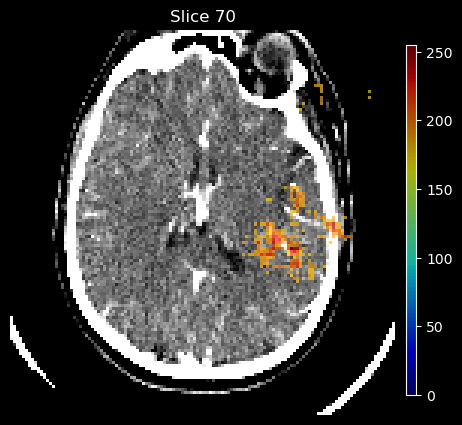

In [14]:
create_attentionmap('MR5821734', 'layer4', 'ggcam', 70)

MR6052759 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 203.0, Max: 203.0, Calculated Threshold: 203.0


/tmp/ipykernel_33549/2277882991.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


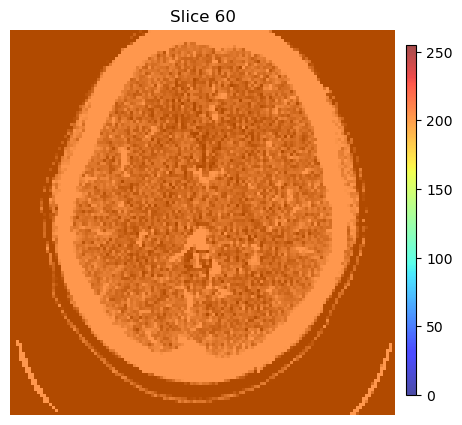

MR95457 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 56.0, Max: 165.0, Calculated Threshold: 110.5


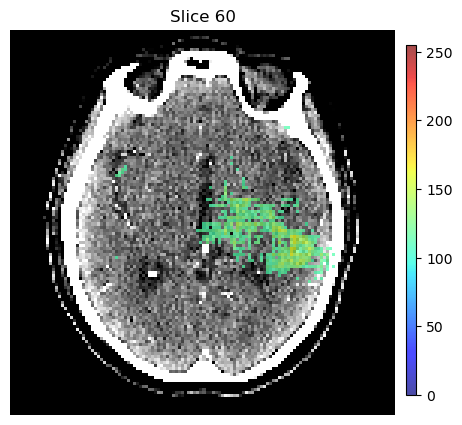

MR278840 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 203.0, Max: 203.0, Calculated Threshold: 203.0


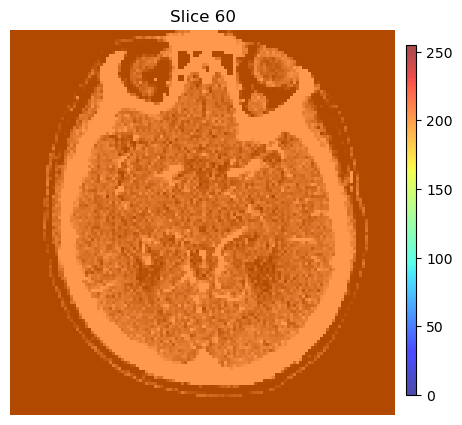

MR2412133 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 254.0, Max: 254.0, Calculated Threshold: 254.0


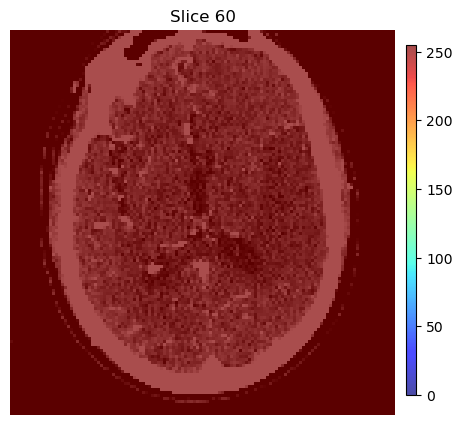

MR5821734 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 75.0, Max: 204.0, Calculated Threshold: 139.5


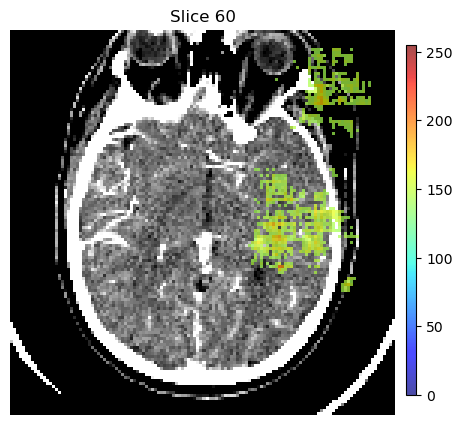

MR1293826 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 239.0, Max: 239.0, Calculated Threshold: 239.0


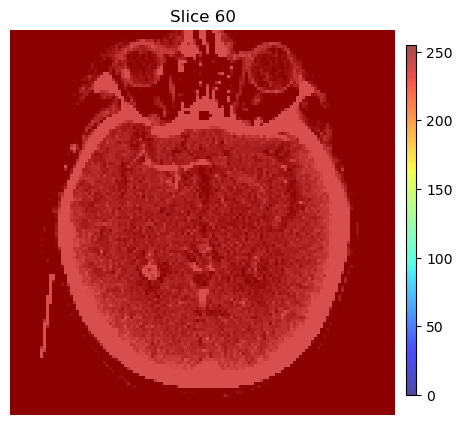

MR6445926 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 168.0, Max: 181.0, Calculated Threshold: 174.5


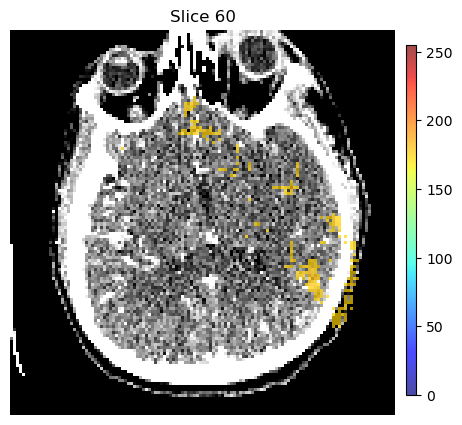

MR4748384 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 213.0, Max: 213.0, Calculated Threshold: 213.0


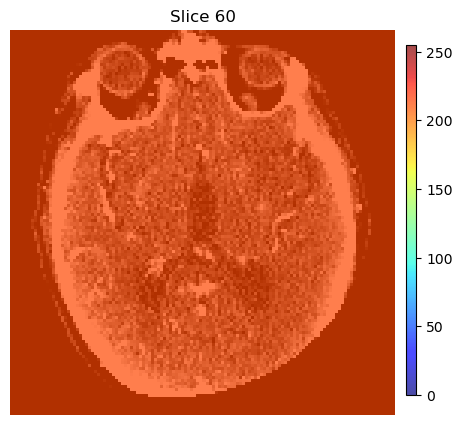

MR3853134 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 161.0, Max: 192.0, Calculated Threshold: 176.5


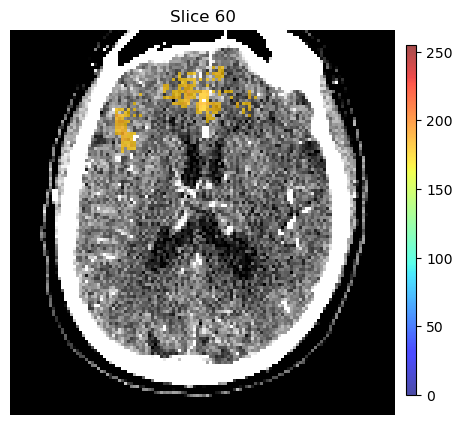

MR6426720 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 193.0, Max: 193.0, Calculated Threshold: 193.0


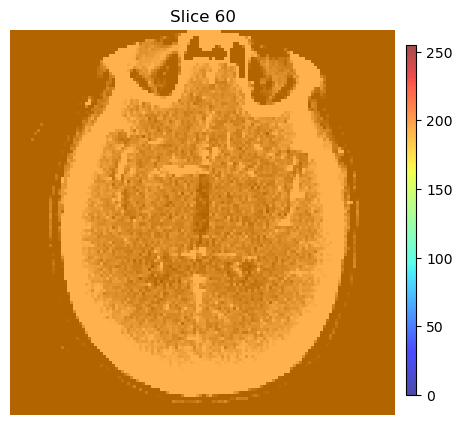

MR655204 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 216.0, Max: 216.0, Calculated Threshold: 216.0


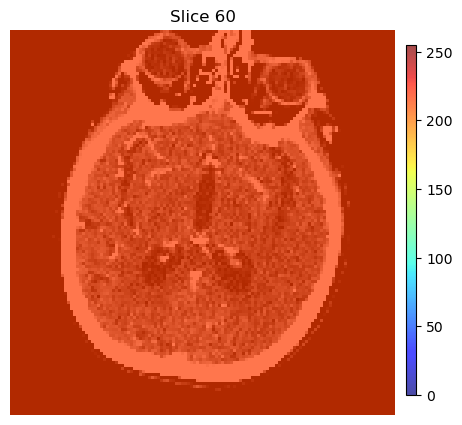

MR1494024 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 76.0, Max: 153.0, Calculated Threshold: 114.5


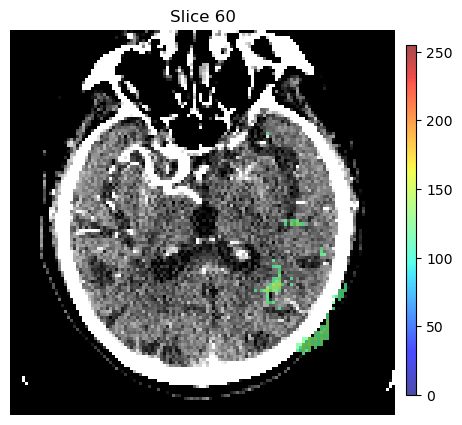

MR5405221 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 223.0, Max: 223.0, Calculated Threshold: 223.0


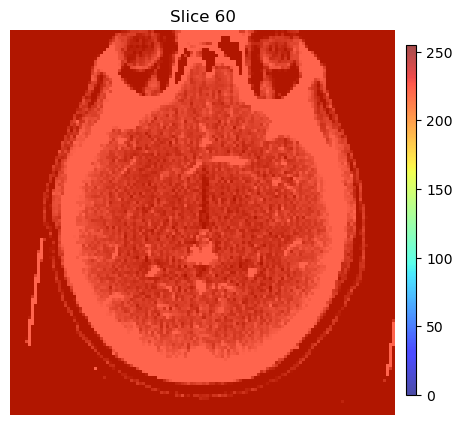

MR718908 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 219.0, Max: 219.0, Calculated Threshold: 219.0


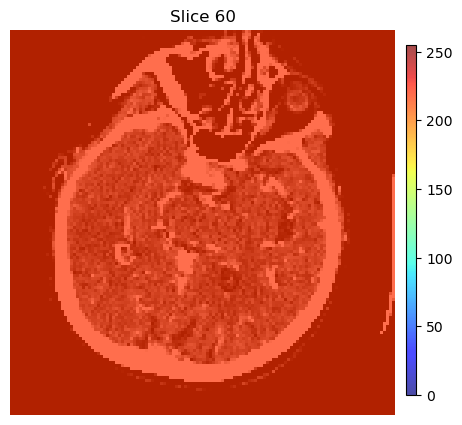

MR5644813 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 203.0, Max: 204.0, Calculated Threshold: 203.5


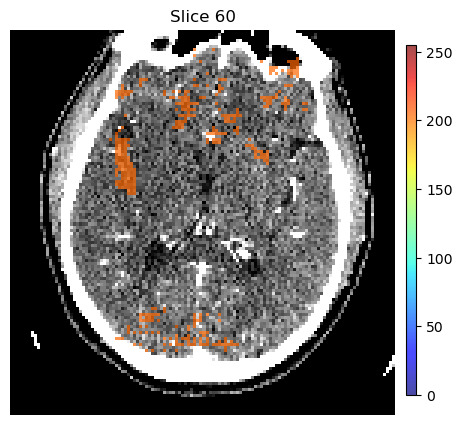

MR1855202 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 211.0, Max: 211.0, Calculated Threshold: 211.0


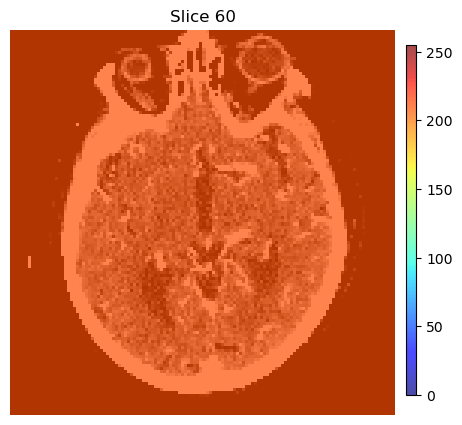

MR4117212 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 115.0, Max: 234.0, Calculated Threshold: 174.5


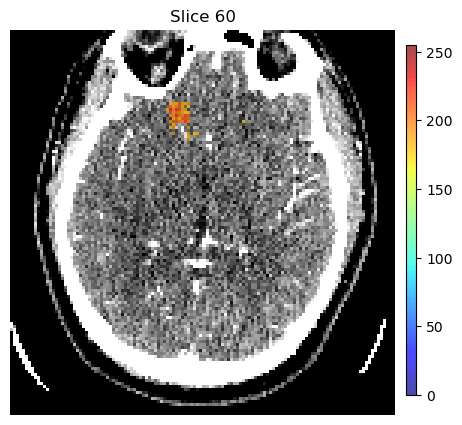

MR389767 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 232.0, Max: 232.0, Calculated Threshold: 232.0


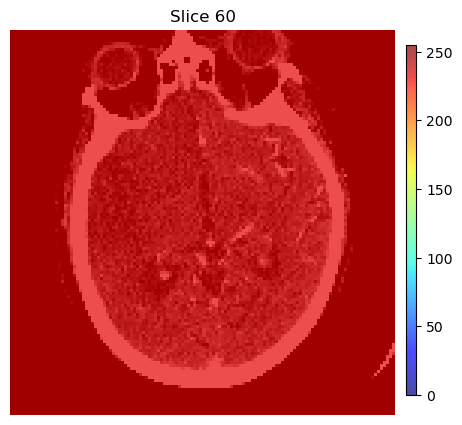

MR2773011 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 202.0, Max: 202.0, Calculated Threshold: 202.0


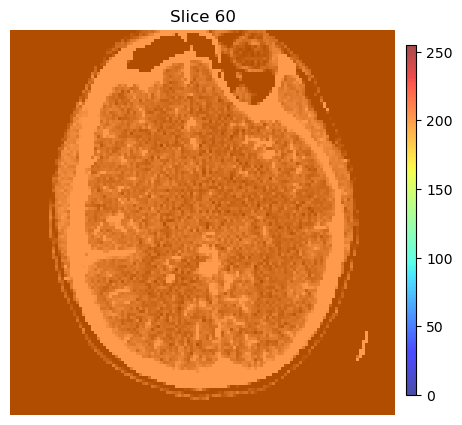

MR304766 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 216.0, Max: 216.0, Calculated Threshold: 216.0


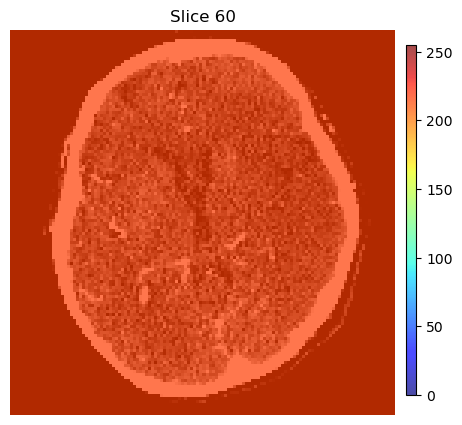

MR2074111 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 229.0, Max: 229.0, Calculated Threshold: 229.0


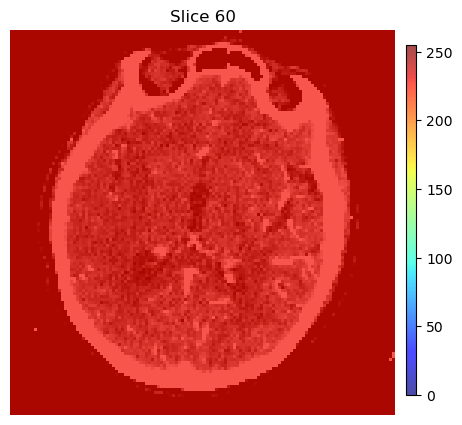

MR4180615 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 227.0, Max: 227.0, Calculated Threshold: 227.0


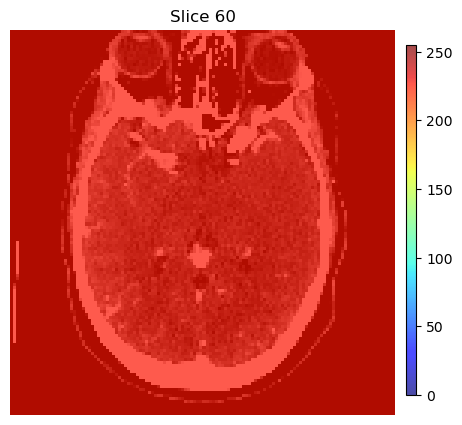

MR2592480 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 95.0, Max: 255.0, Calculated Threshold: 175.0


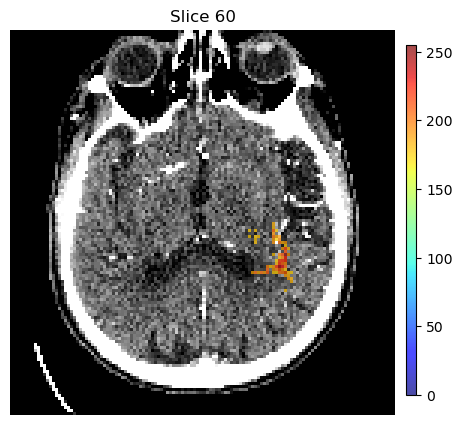

MR1017620 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 248.0, Max: 248.0, Calculated Threshold: 248.0


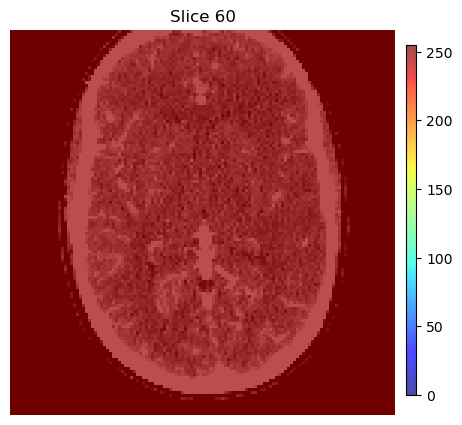

MR6053671 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 223.0, Max: 229.0, Calculated Threshold: 226.0


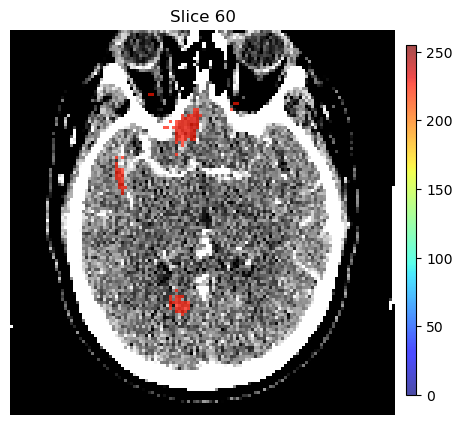

MR5677057 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 191.0, Max: 201.0, Calculated Threshold: 196.0


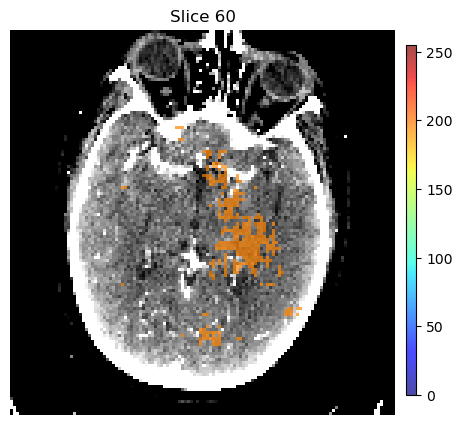

MR959756 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 130.0, Max: 201.0, Calculated Threshold: 165.5


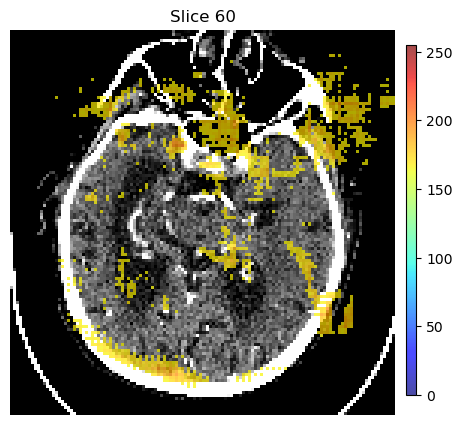

MR1687039 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 99.0, Max: 239.0, Calculated Threshold: 169.0


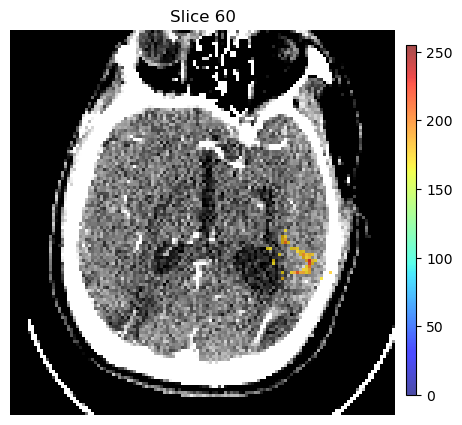

MR6248365 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 150.0, Max: 199.0, Calculated Threshold: 174.5


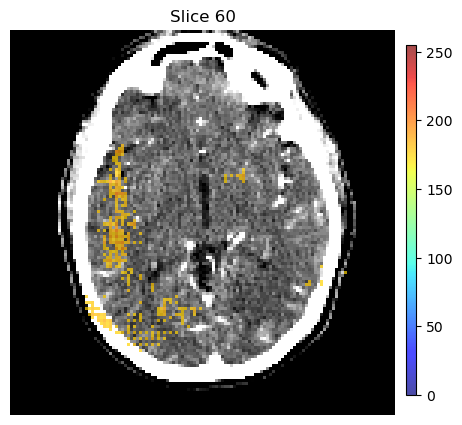

MR4099089 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 129.0, Max: 250.0, Calculated Threshold: 189.5


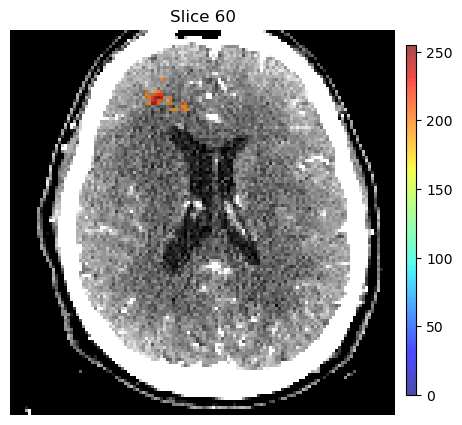

MR2547994 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 140.0, Max: 185.0, Calculated Threshold: 162.5


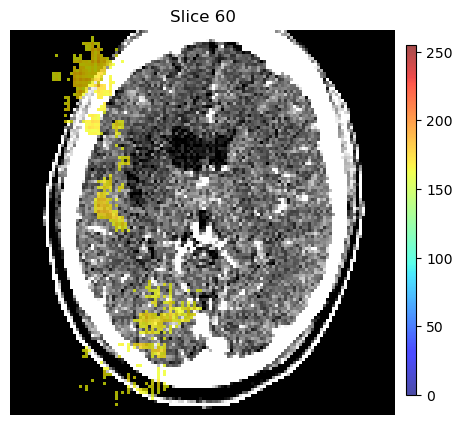

MR1290640 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 190.0, Max: 196.0, Calculated Threshold: 193.0


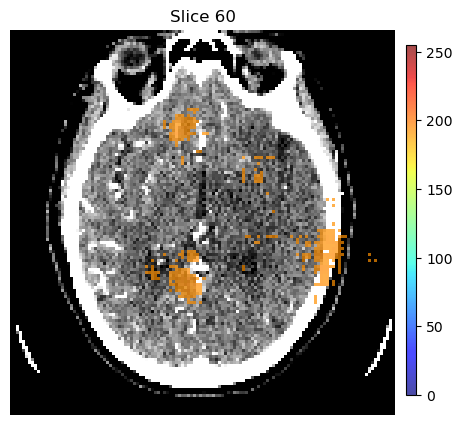

MR1539259 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 175.0, Max: 176.0, Calculated Threshold: 175.5


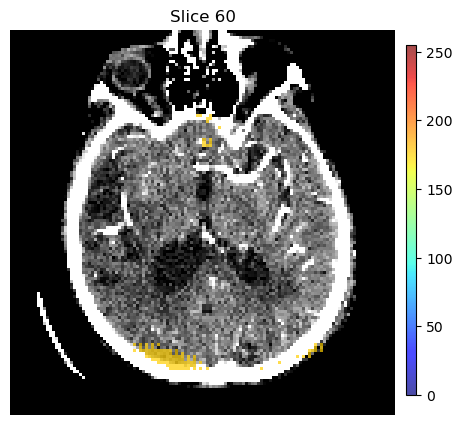

MR1683206 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 82.0, Max: 119.0, Calculated Threshold: 100.5


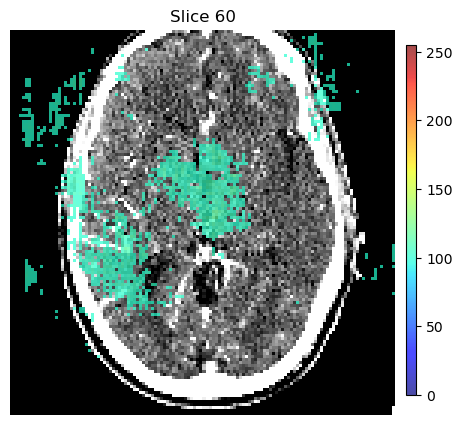

MR895568 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 235.0, Max: 235.0, Calculated Threshold: 235.0


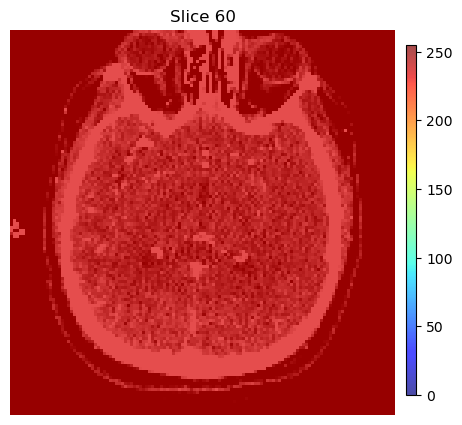

MR3636846 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 132.0, Max: 248.0, Calculated Threshold: 190.0


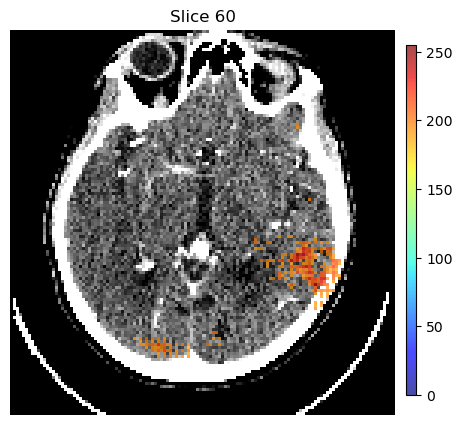

MR1662670 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 210.0, Max: 210.0, Calculated Threshold: 210.0


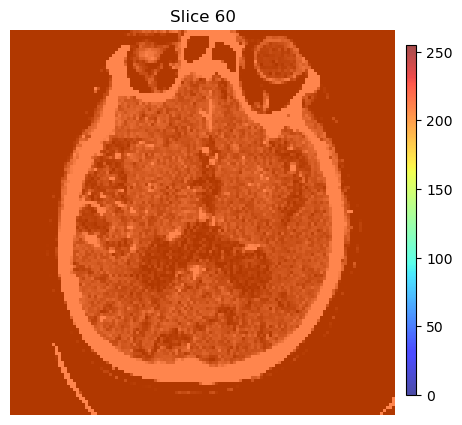

MR3928847 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 232.0, Max: 232.0, Calculated Threshold: 232.0


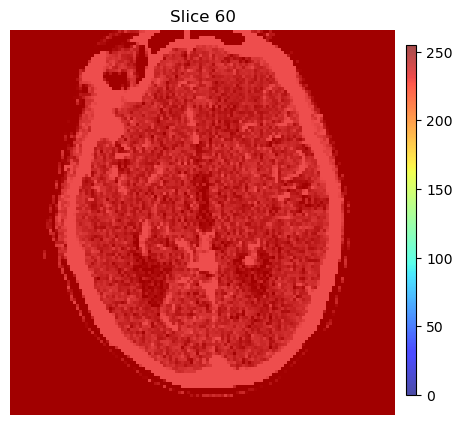

MR4231102 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 213.0, Max: 214.0, Calculated Threshold: 213.5


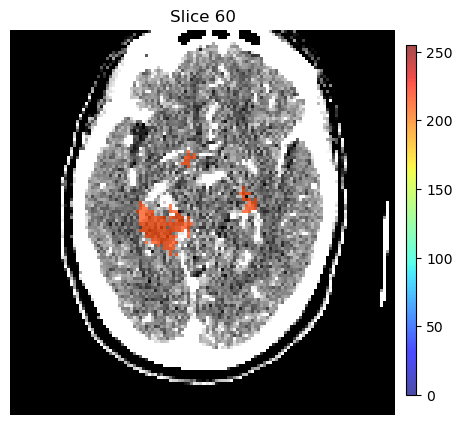

MR6565688 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 90.0, Max: 191.0, Calculated Threshold: 140.5


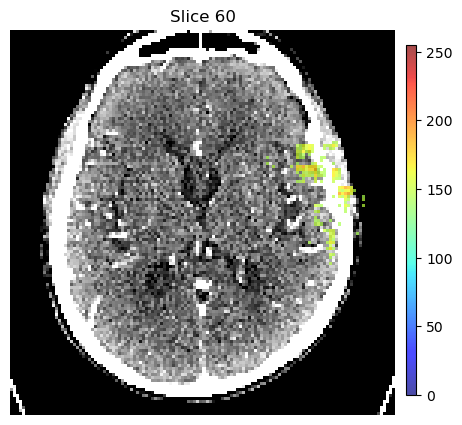

MR4297367 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 230.0, Max: 230.0, Calculated Threshold: 230.0


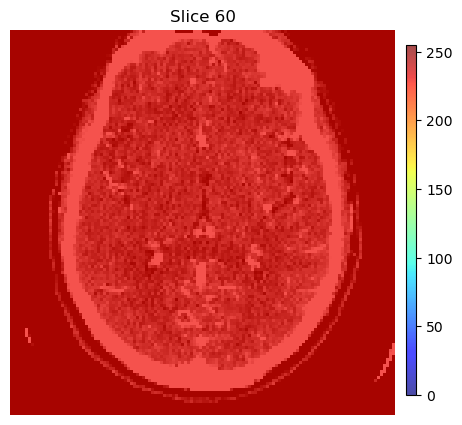

MR37017 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 120.0, Max: 216.0, Calculated Threshold: 168.0


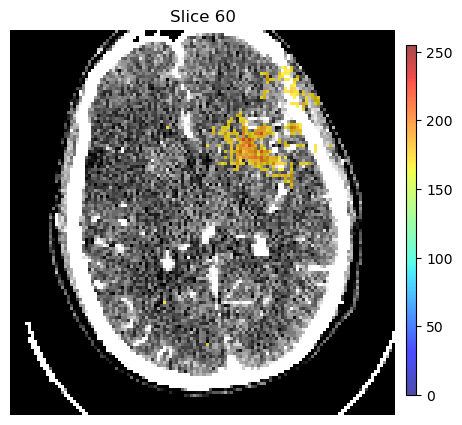

MR2168141 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 188.0, Max: 191.0, Calculated Threshold: 189.5


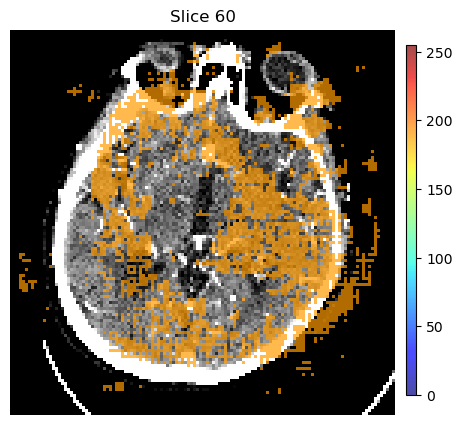

MR4737103 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 223.0, Max: 223.0, Calculated Threshold: 223.0


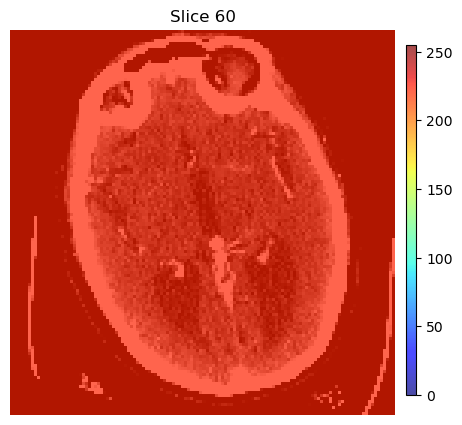

MR6565601 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 252.0, Max: 254.0, Calculated Threshold: 253.0


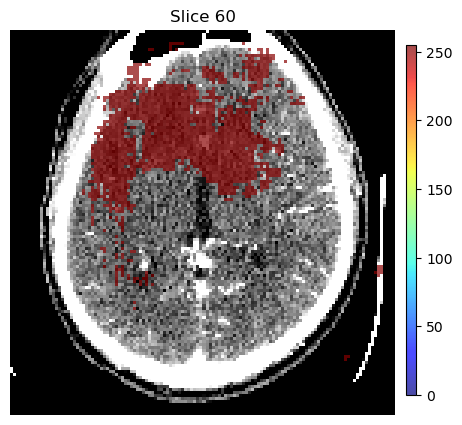

MR4454365 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 224.0, Max: 224.0, Calculated Threshold: 224.0


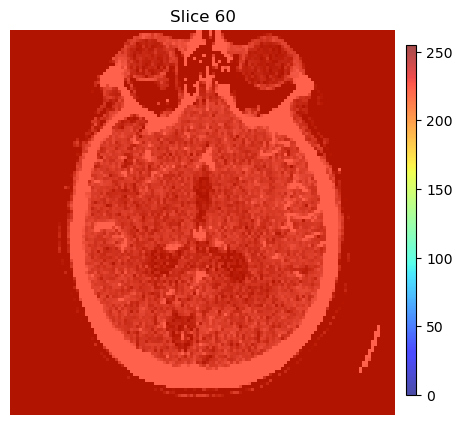

MR5960114 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 103.0, Max: 254.0, Calculated Threshold: 178.5


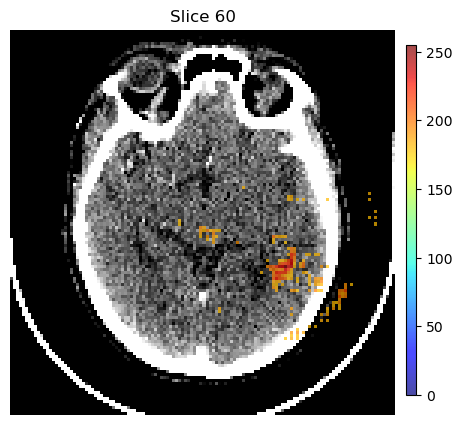

MR5835528 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 140.0, Max: 255.0, Calculated Threshold: 197.5


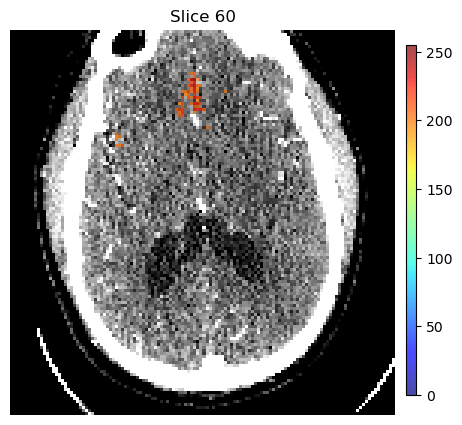

MR1142453 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 212.0, Max: 214.0, Calculated Threshold: 213.0


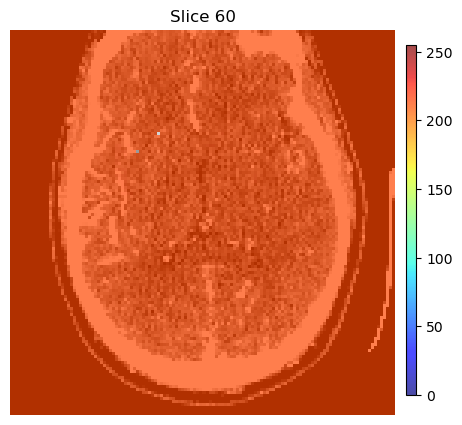

MR569922 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 186.0, Max: 189.0, Calculated Threshold: 187.5


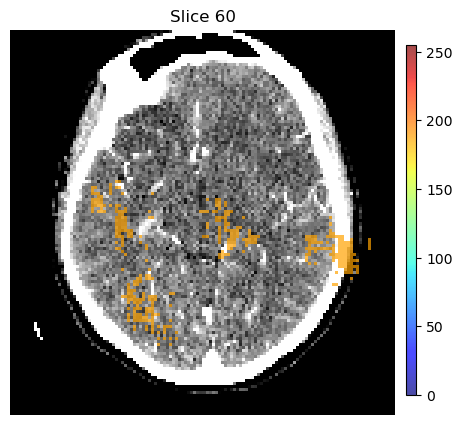

MR1758723 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 240.0, Max: 240.0, Calculated Threshold: 240.0


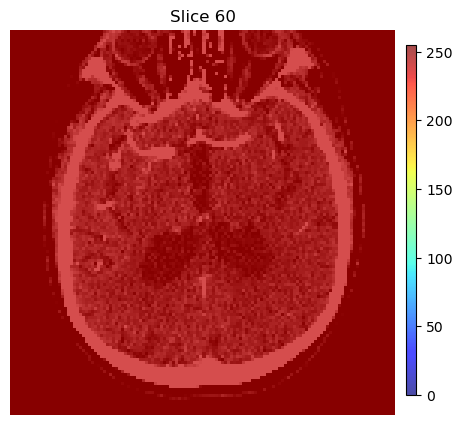

MR655357 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 233.0, Max: 234.0, Calculated Threshold: 233.5


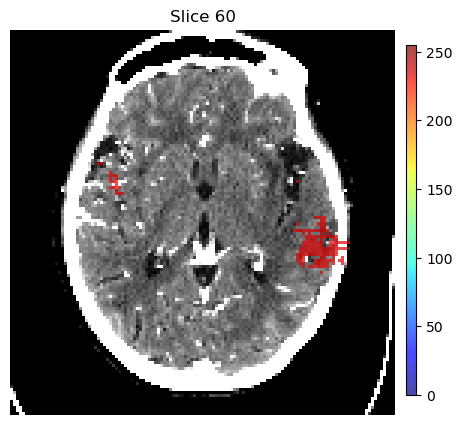

MR1085298 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 104.0, Max: 185.0, Calculated Threshold: 144.5


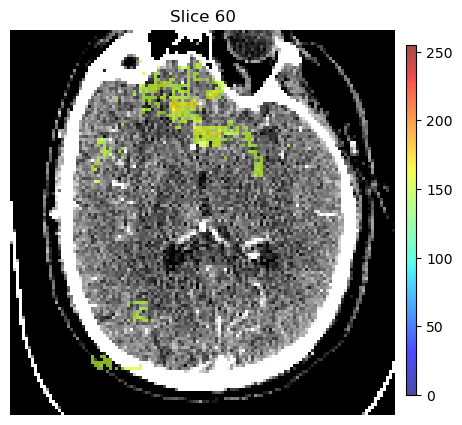

MR6015509 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 98.0, Max: 183.0, Calculated Threshold: 140.5


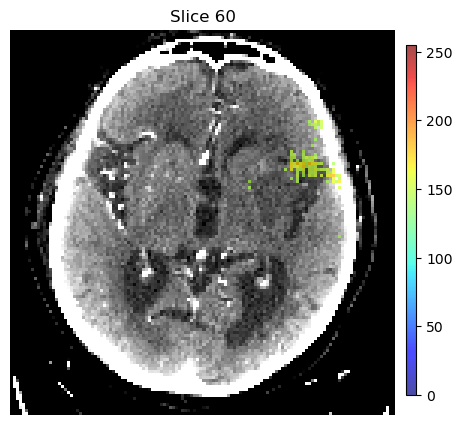

MR1712829 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 220.0, Max: 220.0, Calculated Threshold: 220.0


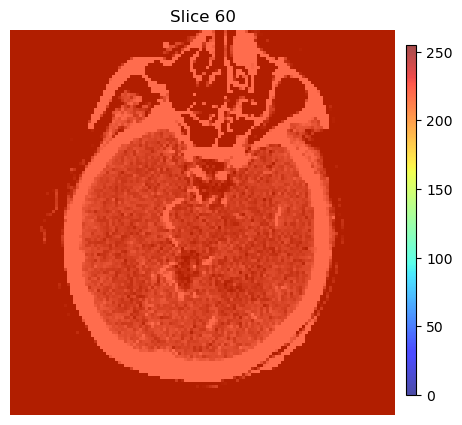

MR6465254 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 219.0, Max: 219.0, Calculated Threshold: 219.0


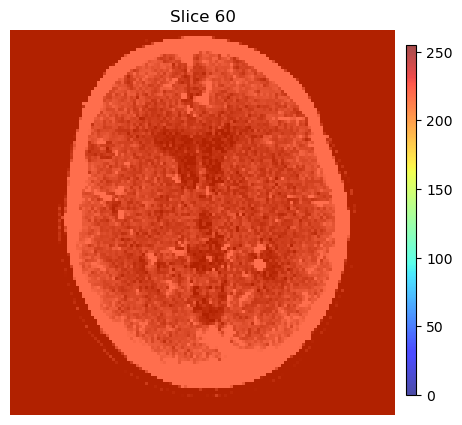

MR693475 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 194.0, Max: 201.0, Calculated Threshold: 197.5


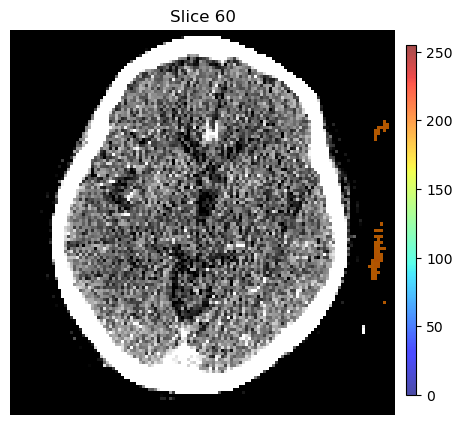

MR4768964 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 234.0, Max: 234.0, Calculated Threshold: 234.0


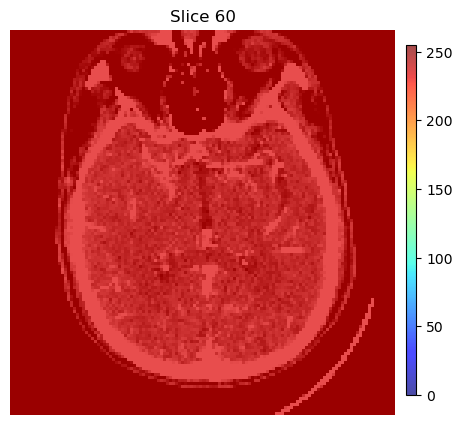

MR1997031 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 240.0, Max: 240.0, Calculated Threshold: 240.0


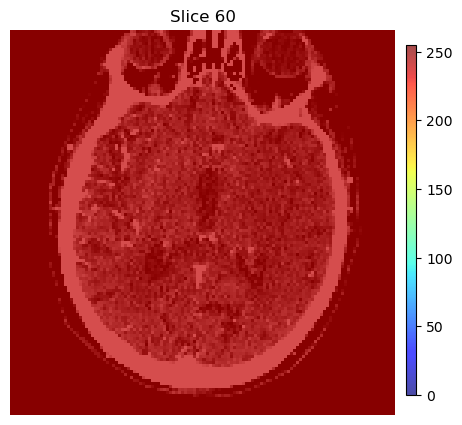

MR2603955 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 237.0, Max: 237.0, Calculated Threshold: 237.0


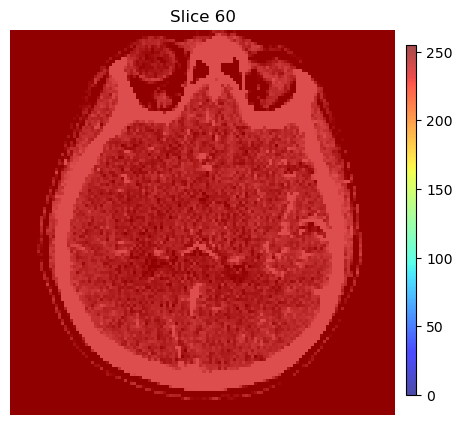

MR5534289 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 219.0, Max: 219.0, Calculated Threshold: 219.0


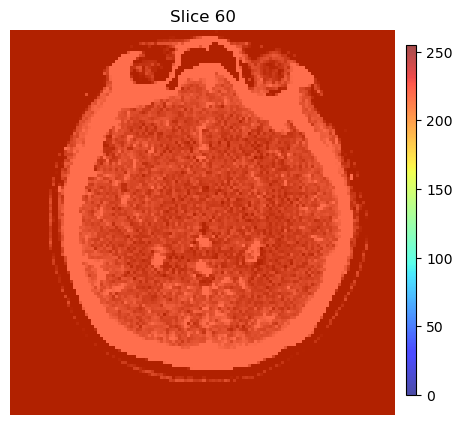

MR3506576 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 227.0, Max: 227.0, Calculated Threshold: 227.0


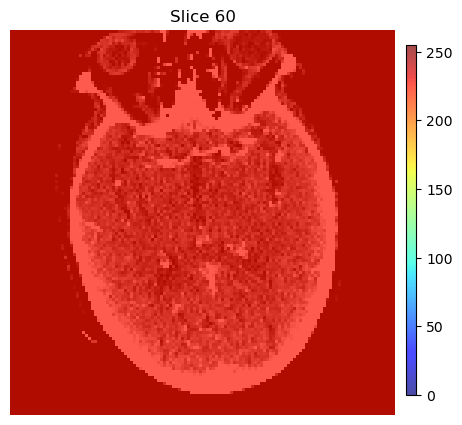

MR3332716 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 105.0, Max: 221.0, Calculated Threshold: 163.0


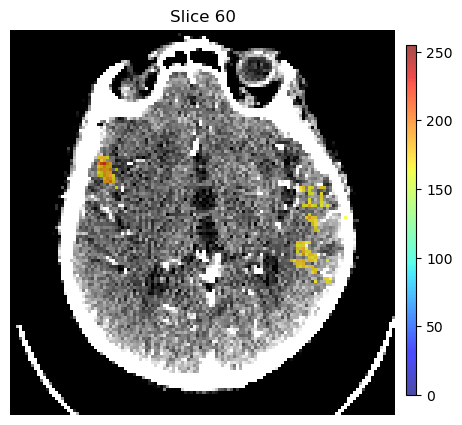

MR1882228 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 92.0, Max: 163.0, Calculated Threshold: 127.5


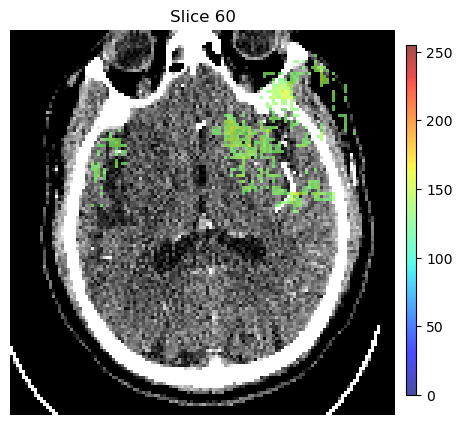

MR1734067 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 105.0, Max: 247.0, Calculated Threshold: 176.0


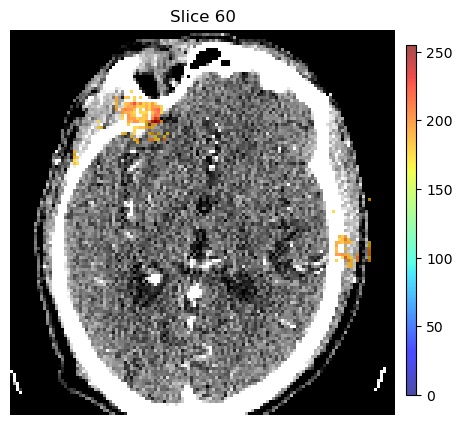

MR6131033 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 112.0, Max: 239.0, Calculated Threshold: 175.5


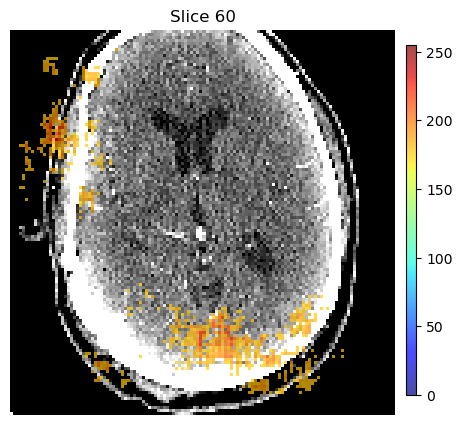

MR3775320 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 232.0, Max: 232.0, Calculated Threshold: 232.0


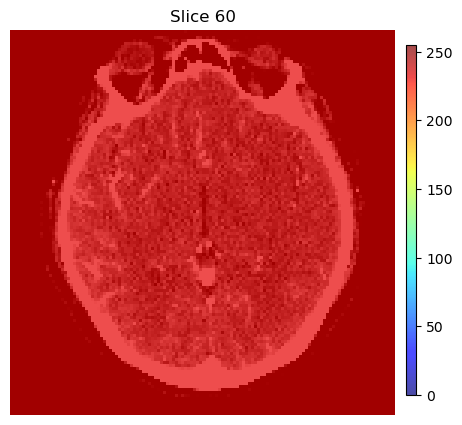

MR170635 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 106.0, Max: 180.0, Calculated Threshold: 143.0


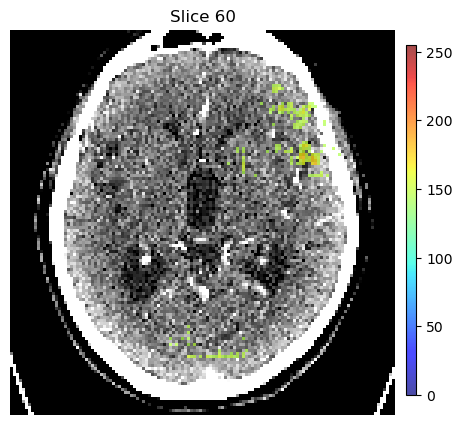

MR6483557 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 97.0, Max: 255.0, Calculated Threshold: 176.0


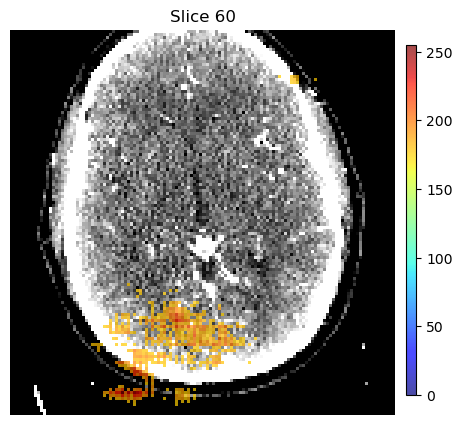

MR2249866 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 187.0, Max: 187.0, Calculated Threshold: 187.0


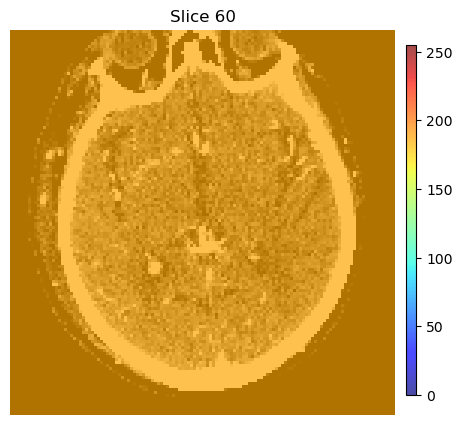

MR5658769 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 82.0, Max: 175.0, Calculated Threshold: 128.5


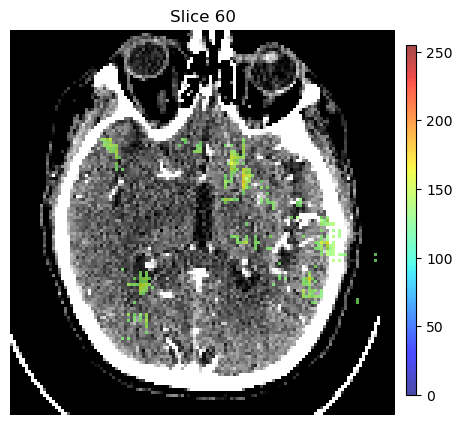

MR4310539 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 203.0, Max: 203.0, Calculated Threshold: 203.0


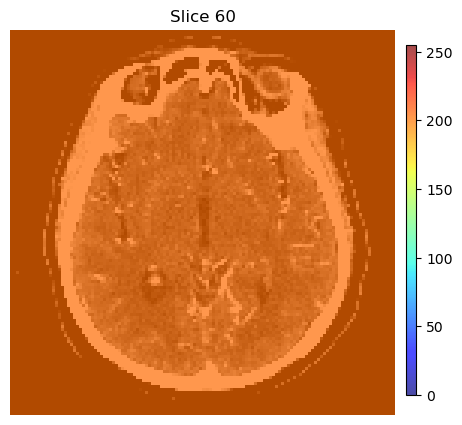

MR135303 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 207.0, Max: 210.0, Calculated Threshold: 208.5


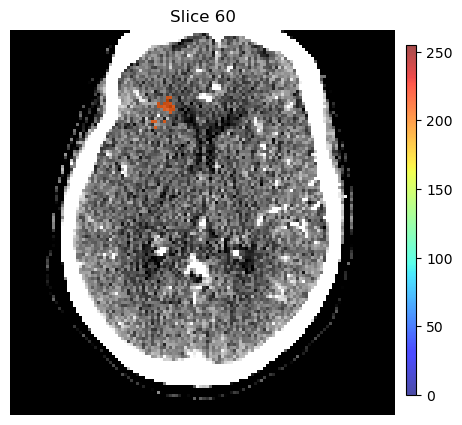

MR6023087 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 241.0, Max: 251.0, Calculated Threshold: 246.0


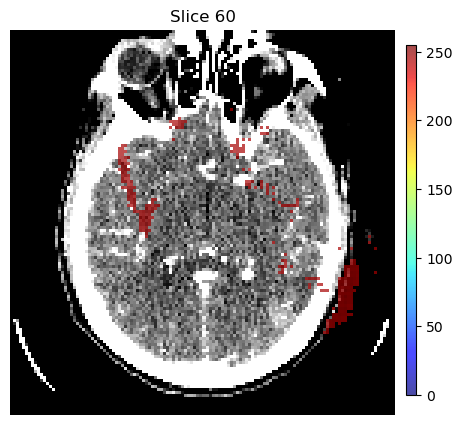

MR30211 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 168.0, Max: 206.0, Calculated Threshold: 187.0


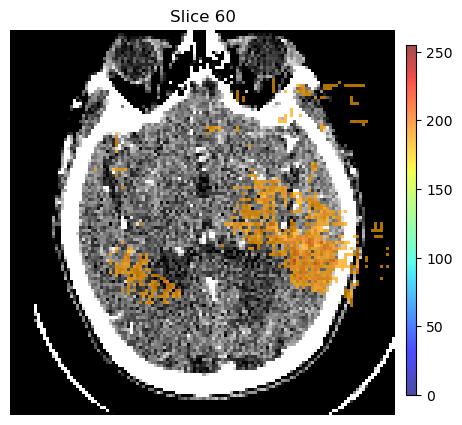

MR4806617 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 243.0, Max: 243.0, Calculated Threshold: 243.0


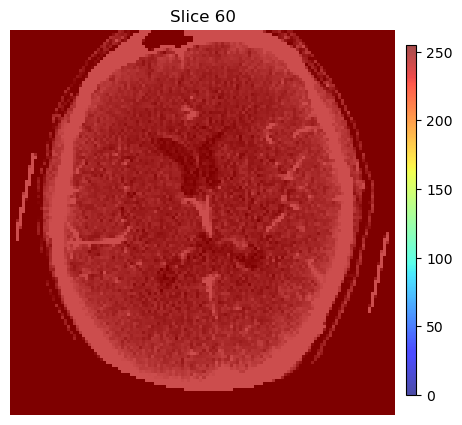

MR1919054 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 223.0, Max: 223.0, Calculated Threshold: 223.0


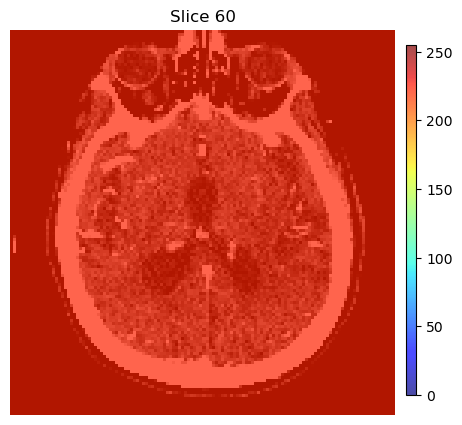

MR3304523 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 116.0, Max: 183.0, Calculated Threshold: 149.5


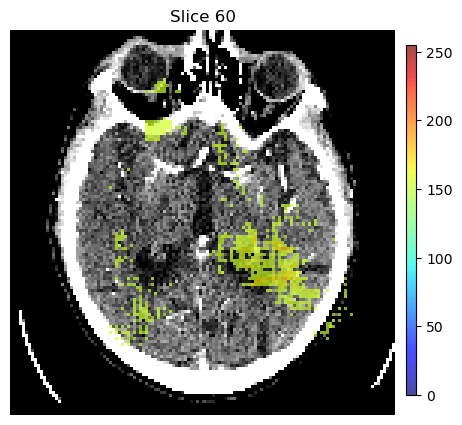

MR4655004 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 244.0, Max: 244.0, Calculated Threshold: 244.0


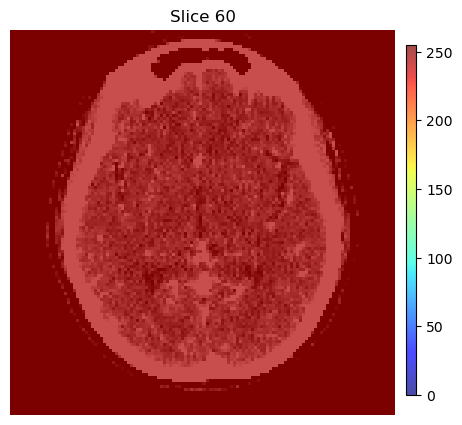

MR1531486 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 248.0, Max: 248.0, Calculated Threshold: 248.0


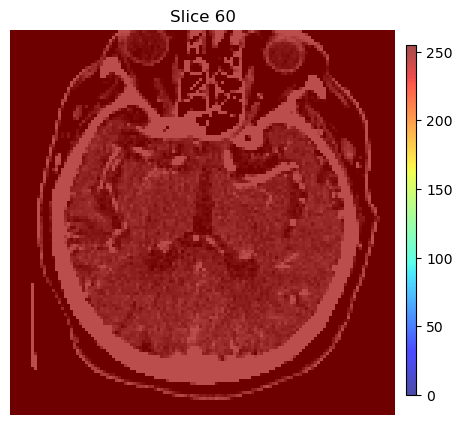

MR1731858 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 223.0, Max: 223.0, Calculated Threshold: 223.0


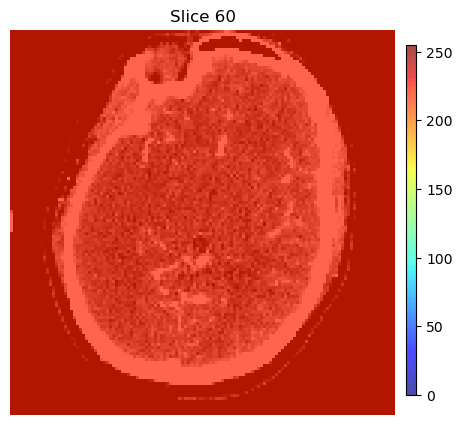

MR2560840 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 226.0, Max: 226.0, Calculated Threshold: 226.0


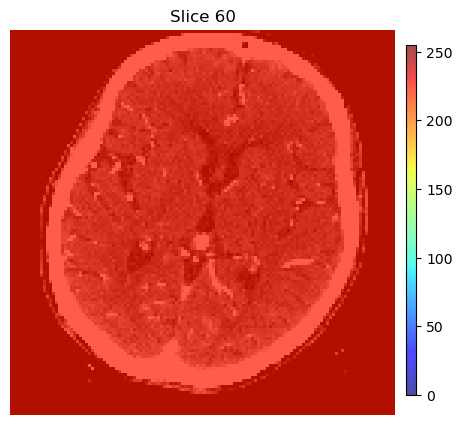

MR3820003 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 125.0, Max: 235.0, Calculated Threshold: 180.0


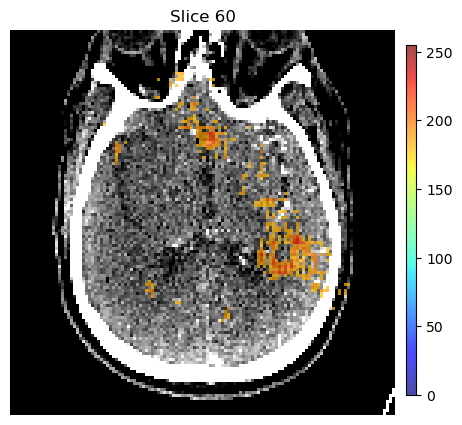

MR4902101 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 206.0, Max: 206.0, Calculated Threshold: 206.0


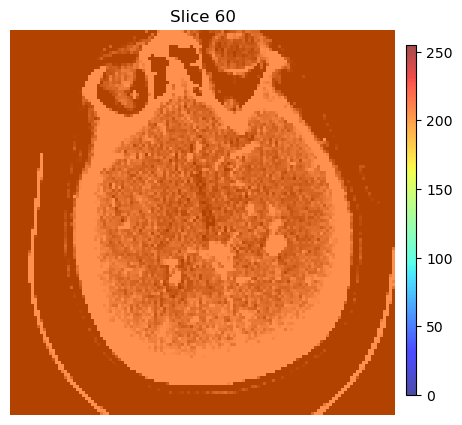

MR1154087 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 215.0, Max: 243.0, Calculated Threshold: 229.0


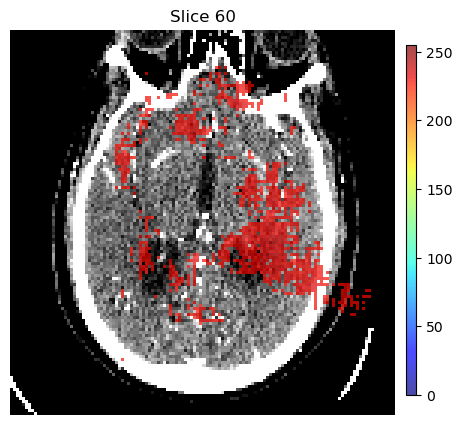

MR1767723 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 196.0, Max: 196.0, Calculated Threshold: 196.0


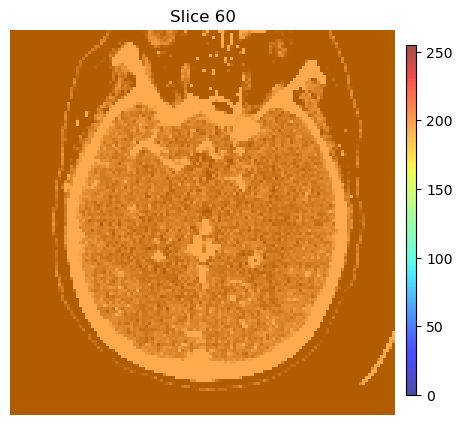

MR1735664 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 98.0, Max: 210.0, Calculated Threshold: 154.0


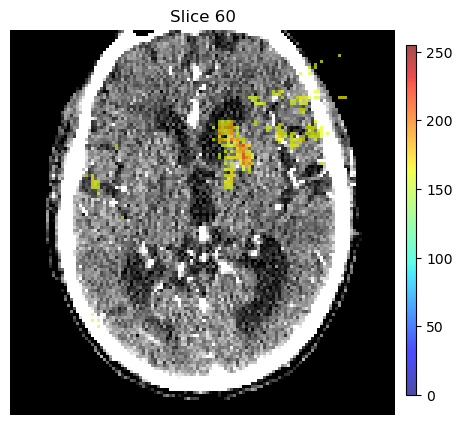

MR4640510 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 121.0, Max: 251.0, Calculated Threshold: 186.0


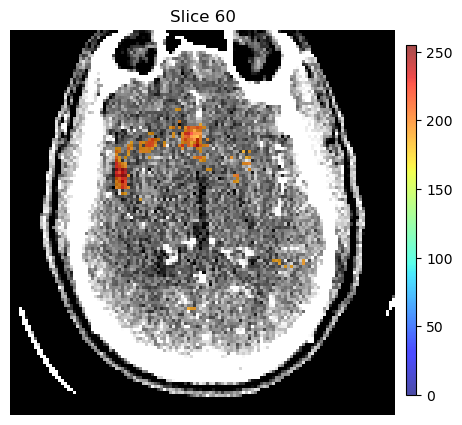

MR703356 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 131.0, Max: 183.0, Calculated Threshold: 157.0


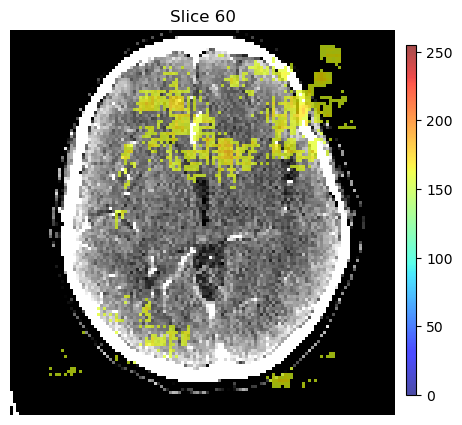

MR1716480 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 181.0, Max: 182.0, Calculated Threshold: 181.5


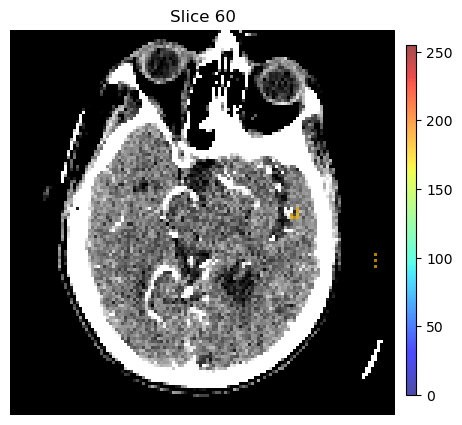

MR656895 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 232.0, Max: 232.0, Calculated Threshold: 232.0


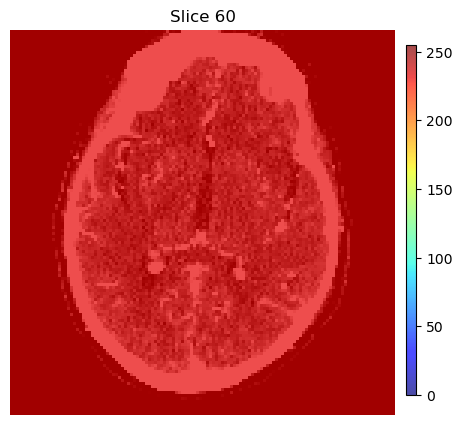

MR6499221 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 219.0, Max: 219.0, Calculated Threshold: 219.0


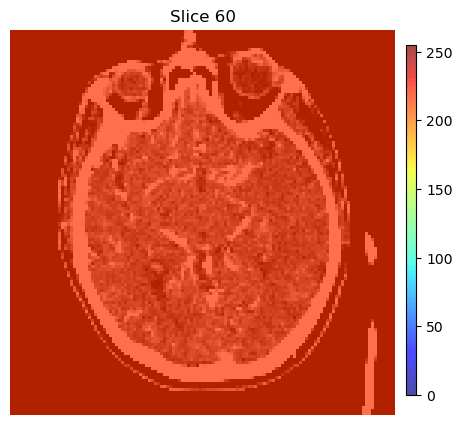

MR4681252 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 246.0, Max: 246.0, Calculated Threshold: 246.0


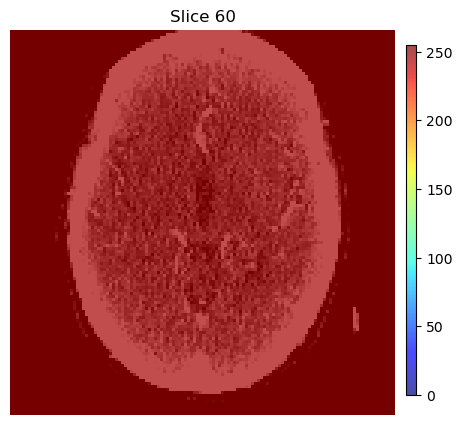

MR4186791 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 230.0, Max: 230.0, Calculated Threshold: 230.0


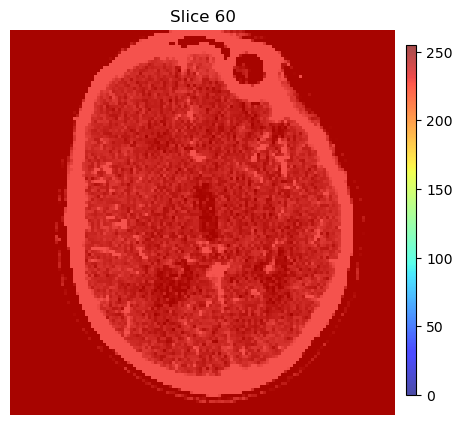

MR2939649 ggcam layer3
torch.Size([1, 1, 128, 128, 128])
Attention_Map shape: (128, 128, 128)
Min: 131.0, Max: 239.0, Calculated Threshold: 185.0


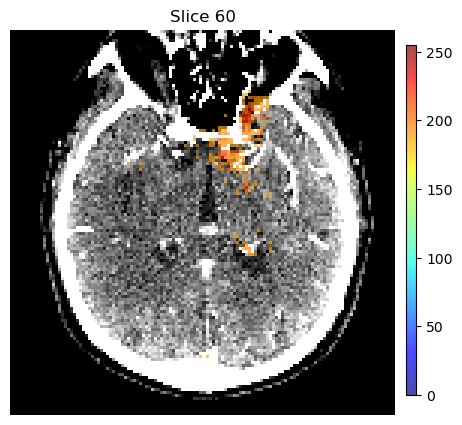

In [35]:
for p in patientlist:
    create_attentionmap(p, 'layer3', 'ggcam')

/tmp/ipykernel_326898/1424756147.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet')


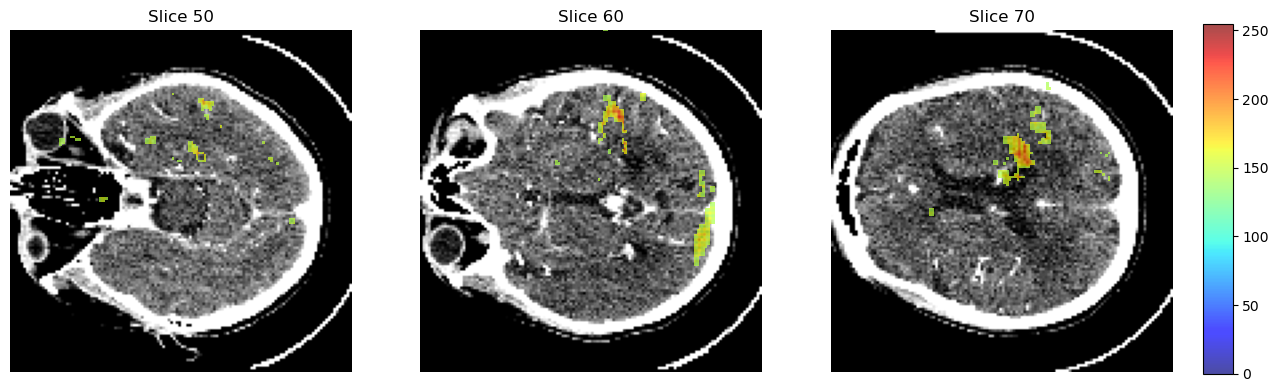

In [22]:
# Printing slides as they are

resize = False
slices = [50, 60, 70]
threshold = 140


if resize == True: 
    # Assuming you have the attention map as a NumPy array called 'attention_map'
    original_image_size = (128, 128, 128)  # Size of the original 3D image
    resized_attention_map = zoom(attention_map, original_image_size / np.array(attention_map.shape), order=1)
    normalized_attention_map = resized_attention_map
else:
    normalized_attention_map = attention_map
original_image = img_data
original_image[original_image > 100] = 100
original_image[original_image < 0] = 0

def plot_slices(original, attention, slices, threshold):
    num_slices = len(slices)
    fig, axes = plt.subplots(1, num_slices, figsize=(5*num_slices, 5))
    
    for i, slice_idx in enumerate(slices):
        # Replace 'axis' with the appropriate axis for the third dimension of your image data
        axes[i].imshow(original[:, :, slice_idx], cmap='gray')
        
        masked_attention = np.ma.masked_less(attention[:, :, slice_idx], threshold)
        cmap = plt.cm.get_cmap('jet')
        
        im = axes[i].imshow(masked_attention, cmap=cmap, alpha=0.7, vmin=np.min(attention), vmax=np.max(attention))

        axes[i].set_title(f"Slice {slice_idx}")
        axes[i].axis('off')
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
plot_slices(original_image, normalized_attention_map, slices, threshold=threshold)

In [29]:
am_nifti = nib.Nifti1Image(normalized_attention_map, affine=np.eye(4))
output_path = "attention_maps/output.nii.gz"
nib.save(am_nifti, output_path)